In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
import torch
# import torchvision
# import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

In [8]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

train_images = train_images / 255.0
test_images = test_images / 255.0

print(train_images.shape)
print(train_labels.shape)
print(train_labels)

print(test_images.shape)
print(test_labels.shape)
print(test_labels)

(60000, 28, 28)
(60000,)
[9 0 0 ... 3 0 5]
(10000, 28, 28)
(10000,)
[9 2 1 ... 8 1 5]


In [9]:
tensor_x = torch.tensor(train_images, dtype=torch.float)
tensor_y = torch.tensor(train_labels, dtype=torch.long)
train_dataset = TensorDataset(tensor_x, tensor_y)
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)

tensor_x = torch.tensor(test_images, dtype=torch.float)
tensor_y = torch.tensor(test_labels, dtype=torch.long)
test_dataset = TensorDataset(tensor_x,tensor_y)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=True)

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 10)

    def hidden_layer(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        return x

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
def train_network(net, lambda_reg, nepochs):
  for it in range(nepochs):
    for x, t in train_dataloader:
      # Reset gradients to 0:
      optimizer.zero_grad()

      # Forward pass:
      outputs = net(x)
      loss = criterion(outputs, t)

      # L1 regularization:
      l1_term = torch.norm(net.fc1.weight, p=1) + torch.norm(net.fc2.weight, p=1)
      loss += lambda_reg * l1_term

      # Backward pass:
      loss.backward()

      # Actualización de los pesos:
      optimizer.step()

    # Imprimir loss de la época:
    input = torch.tensor(train_images, dtype=torch.float)
    out = net(input)
    _, predicted = torch.max(out, 1)
    acc = (predicted.numpy() == train_labels).sum() / 60000
    print('[%d] loss: %.3f, training acc: %.3f' % (it + 1, loss.item(), acc))

In [12]:
def get_num_internal_states(net, num_bins=10):
  input = torch.tensor(train_images, dtype=torch.float)
  activations = net.hidden_layer(input)
  activations = activations.detach().numpy()

  # Histograma de cada columna:
  _, bin_edges = np.histogram(activations, bins=num_bins)
  bin_edges[-1] = bin_edges[-1] + 0.01*(bin_edges[-1] - bin_edges[-2])
  b = np.zeros_like(activations)
  for i in range(activations.shape[1]):
    #_, bin_edges = np.histogram(activations[:, i], bins=num_bins)
    #bin_edges[-1] = bin_edges[-1] + 0.01*(bin_edges[-1] - bin_edges[-2])
    b[:, i] = np.digitize(activations[:, i], bin_edges)

  num_states = np.unique(b, axis=0).shape[0]
  print(f"Number of internal states: {num_states}")
  return num_states

In [13]:
def get_num_internal_states_new(net, bin_edges):
  input = torch.tensor(train_images, dtype=torch.float)
  activations = net.hidden_layer(input)
  activations = activations.detach().numpy()

  b = np.zeros_like(activations)
  for i in range(activations.shape[1]):
    b[:, i] = np.digitize(activations[:, i], bin_edges)

  num_states = np.unique(b, axis=0).shape[0]
  print(f"Number of internal states: {num_states}")
  return num_states

### Usando los mismos bins para todas las redes

In [9]:
nveces = 5
reg_values = np.logspace(-5, 0, 10)
num_states = []
acc = []
input = torch.tensor(train_images, dtype=torch.float)

# Red sin regularizar para calcular los bins:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
train_network(net, 0, 2)
input = torch.tensor(train_images, dtype=torch.float)
activations = net.hidden_layer(input)
activations = activations.detach().numpy()
_, bin_edges = np.histogram(activations, bins=10)

for lreg in reg_values:
  print("-"*60)
  print(f" lreg = {lreg}")
  print("-"*60)
  num_states_i = 0
  acc_i = 0
  for i in range(nveces):
    net = Net()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters())
    train_network(net, lreg, 2)
    num_states_i += get_num_internal_states_new(net, bin_edges)
    out = net(input)
    _, predicted = torch.max(out, 1)
    acc_i += ((predicted.numpy() == train_labels).sum() / 60000)

  num_states.append(num_states_i/nveces)
  acc.append(acc_i/nveces)

[1] loss: 0.402, training acc: 0.842
[2] loss: 0.295, training acc: 0.857
------------------------------------------------------------
 lreg = 1e-05
------------------------------------------------------------
[2] loss: 0.295, training acc: 0.857
------------------------------------------------------------
 lreg = 1e-05
------------------------------------------------------------
[1] loss: 0.526, training acc: 0.844
[1] loss: 0.526, training acc: 0.844
[2] loss: 0.369, training acc: 0.858
[2] loss: 0.369, training acc: 0.858
Number of internal states: 51881
Number of internal states: 51881
[1] loss: 0.364, training acc: 0.843
[1] loss: 0.364, training acc: 0.843
[2] loss: 0.476, training acc: 0.856
[2] loss: 0.476, training acc: 0.856
Number of internal states: 53282
Number of internal states: 53282
[1] loss: 0.423, training acc: 0.843
[1] loss: 0.423, training acc: 0.843
[2] loss: 0.344, training acc: 0.859
[2] loss: 0.344, training acc: 0.859
Number of internal states: 51865
Number o

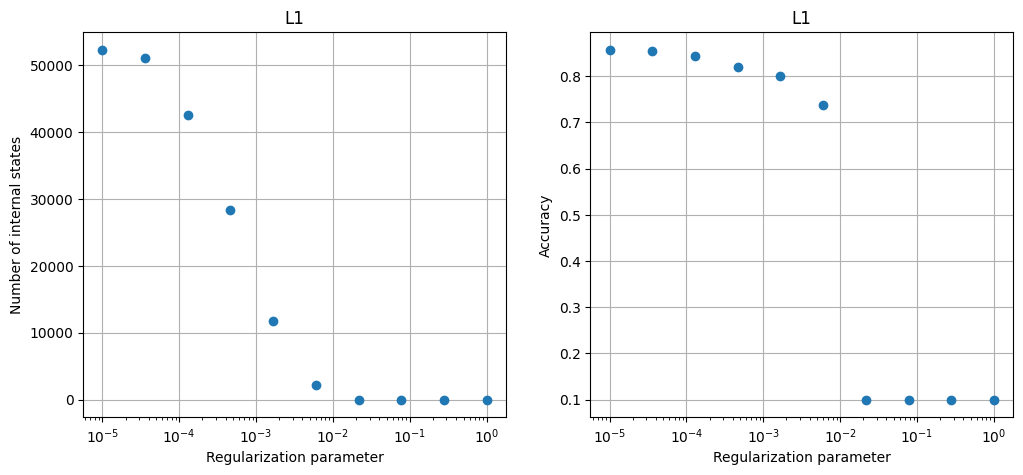

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(reg_values, num_states, 'o')
plt.xlabel('Regularization parameter')
plt.ylabel('Number of internal states')
plt.xscale('log')
plt.title('L1')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(reg_values, acc, 'o')
plt.xlabel('Regularization parameter')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.title('L1')
plt.grid(True)

plt.show()

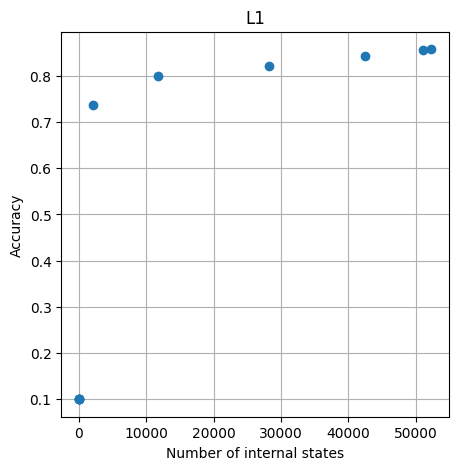

In [11]:
plt.figure(figsize=(5, 5))
plt.plot(num_states, acc, 'o')
plt.xlabel('Number of internal states')
plt.ylabel('Accuracy')
plt.title('L1')
plt.grid(True)
plt.show()

### Cada red tiene sus bins

## Sección añadida: Pruebas propuestas y visualización de la geometría (antes de la sección final)

A continuación están las 10 pruebas propuestas para estudiar en detalle el efecto de L1/L2 sobre el número de estados, y las utilidades para generar la figura 3x4 de la geometría de activaciones. Esta sección está situada inmediatamente después de la sección de tu profesor (que usa 50 bins) y antes de la sección final añadida previamente.

Nota: las funciones aquí son autocontenidas y usan la clase `Net` y los `dataloaders` ya definidos en el notebook. Para ejecuciones rápidas usa pocos epochs (2) y pocos seeds (2).

### Lista de 10 pruebas (resumen)
1. Barrido fino L1 (1e-2..1.0)
2. Barrido fino L2 (1e-2..1.0)
3. Ablation por capa L1 (fc1, fc2, ambas)
4. Warm-up L1 (activar L1 después de W épocas)
5. Sensibilidad eps (DBSCAN)
6. Comparación de métodos de conteo (DBSCAN, rounding, Agglomerative, KMeans)
7. Efecto del preprocesado/activation scaling (0..1 vs z-score)
8. Reproducibilidad por seed/fold (≥5 seeds)
9. Evolución temporal: n_states por época
10. Diagnóstico de pesos y activaciones (histogramas)

Ejecuta las pruebas de manera incremental y guarda resultados en DataFrames/CSV para análisis posterior.

In [14]:
# Helpers para entrenar modelos cortos (usar para construir la cuadrícula 3x4)
import copy

def train_net_with_reg(reg_type, reg_val, epochs=2, seed=0, device='cpu', l1_mask=('fc1','fc2')):
    # reg_type: 'L1'|'L2'|'baseline'
    torch.manual_seed(1000 + seed)
    net = Net().to(device)
    criterion = nn.CrossEntropyLoss()
    if reg_type == 'L2':
        optimizer = optim.Adam(net.parameters(), weight_decay=float(reg_val))
    else:
        optimizer = optim.Adam(net.parameters())
    for ep in range(epochs):
        net.train()
        for x,t in train_dataloader:
            optimizer.zero_grad()
            out = net(x)
            loss = criterion(out, t)
            if reg_type == 'L1':
                l1_term = 0.0
                if 'fc1' in l1_mask:
                    l1_term = l1_term + torch.norm(net.fc1.weight, p=1)
                if 'fc2' in l1_mask:
                    l1_term = l1_term + torch.norm(net.fc2.weight, p=1)
                loss = loss + float(reg_val) * l1_term
            loss.backward()
            optimizer.step()
    return net

# Construir grid de nets: rows = ['baseline','L1','L2'], cols = [vals4] -> retorna lista de listas (3x4)
def build_nets_grid(reg_list, param_list, epochs=2, seed=0, device='cpu'):
    nets = []
    for reg in reg_list:
        row = []
        for val in param_list:
            if reg == 'baseline':
                net = train_net_with_reg('baseline', 0.0, epochs=epochs, seed=seed, device=device)
            else:
                net = train_net_with_reg(reg, val, epochs=epochs, seed=seed, device=device)
            row.append(net)
        nets.append(row)
    return nets

In [15]:
# Plot: geometría activaciones, grid 3x4
import matplotlib.pyplot as plt
import numpy as np

def plot_activation_geometry_grid(nets_grid, labels_rows, params_cols, N_images=200, standardize=True, figsize=(16,10), alpha=0.06):
    n_rows = len(labels_rows)
    n_cols = len(params_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, sharex=True)
    # sample images
    X_all = train_images.reshape(-1, 28*28)
    N_total = X_all.shape[0]
    idx = np.random.RandomState(0).choice(N_total, min(N_images, N_total), replace=False)
    Xs = X_all[idx]
    x_axis = np.arange(Xs.shape[0])

    for i_row in range(n_rows):
        for j_col in range(n_cols):
            ax = axes[i_row][j_col] if n_rows>1 else axes[j_col]
            net = nets_grid[i_row][j_col]
            if net is None:
                ax.set_title(f"{labels_rows[i_row]} | {params_cols[j_col]}\n(no model)")
                ax.set_xticks([])
                ax.set_yticks([])
                continue
            with torch.no_grad():
                H = net.hidden_layer(torch.tensor(Xs, dtype=torch.float)).cpu().numpy()
            H_plot = H.copy()
            if standardize:
                mu = H_plot.mean(axis=0, keepdims=True)
                sd = H_plot.std(axis=0, keepdims=True)
                sd[sd == 0] = 1.0
                H_plot = (H_plot - mu) / sd
            n_neurons = H_plot.shape[1]
            for j in range(n_neurons):
                ax.plot(x_axis, H_plot[:, j], color='C0', alpha=alpha, linewidth=0.6)
            median_curve = np.median(H_plot, axis=1)
            p10 = np.percentile(H_plot, 10, axis=1)
            p90 = np.percentile(H_plot, 90, axis=1)
            ax.plot(x_axis, median_curve, color='C1', linewidth=1.2, label='median')
            ax.fill_between(x_axis, p10, p90, color='C1', alpha=0.15, label='10-90p')
            ax.set_title(f"{labels_rows[i_row]} | {params_cols[j_col]}")
            if i_row == n_rows - 1:
                ax.set_xlabel('image index (sampled)')
            if j_col == 0:
                ax.set_ylabel('activation (per neuron)' + (' (z)' if standardize else ''))
            ax.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

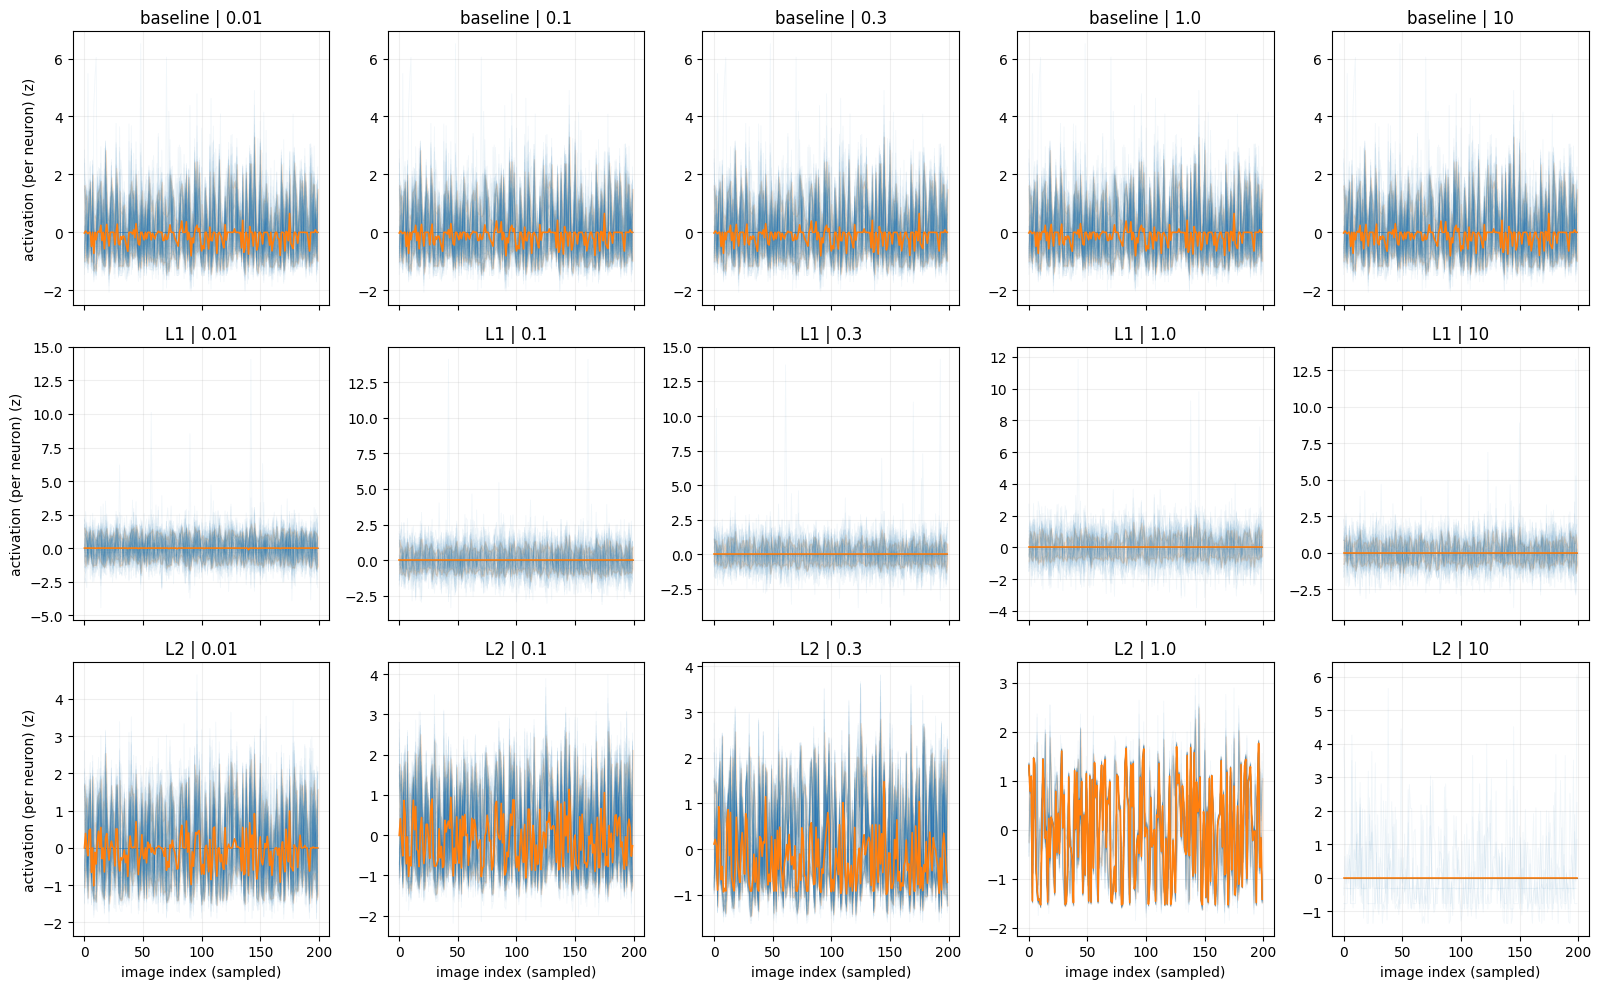

In [16]:
# Ejemplo: construir una cuadrícula pequeña y dibujar la geometría de activaciones (rápido)
# WARNING: esto entrena modelos rápidos (epochs=2) en CPU; ajústalo si quieres mayor fidelidad.
reg_rows = ['baseline', 'L1', 'L2']
reg_vals = [1e-2, 1e-1, 3e-1, 1.0, 10]  # 4 columnas
# Construir modelos rápidos (usa epochs=2 para exploración rápida)
nets = build_nets_grid(reg_rows, reg_vals, epochs=2, seed=0, device='cpu')
# Dibujar la cuadrícula 3x4
plot_activation_geometry_grid(nets, labels_rows=reg_rows, params_cols=[str(v) for v in reg_vals], N_images=200, standardize=True)

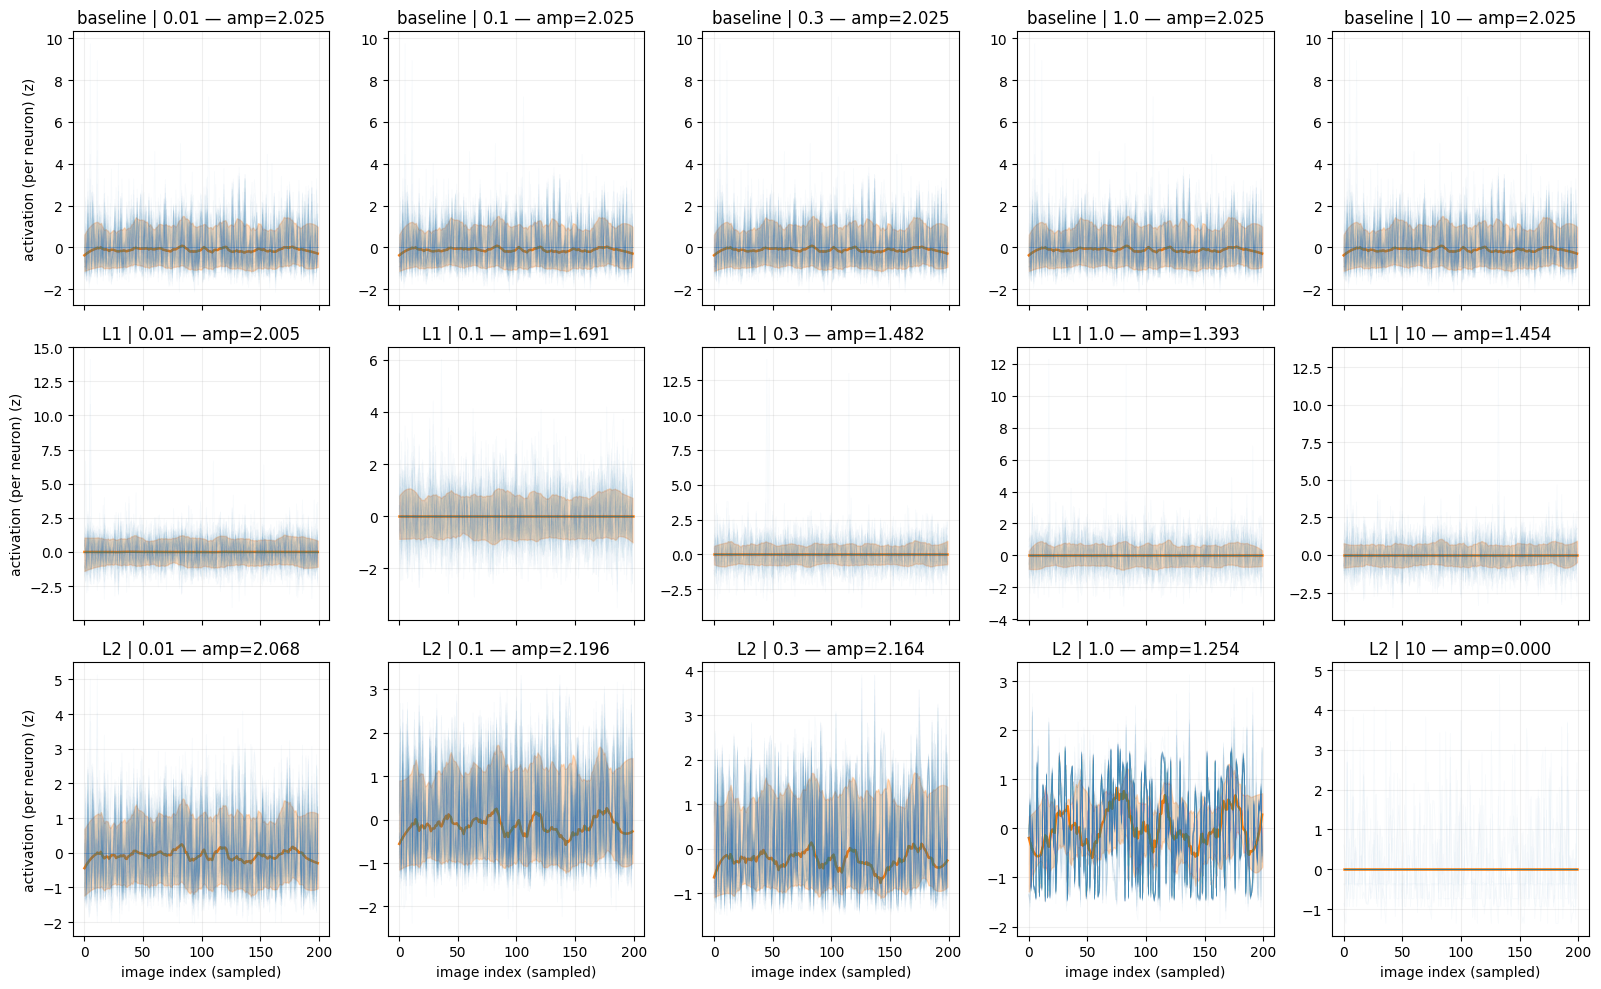

In [17]:
# Nueva visualización: versión suavizada y más clara (conserva la original)
# Suavizamos la mediana y la banda 10-90 usando Savitzky-Golay y un filtro gaussiano para la banda.
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
import numpy as np
import matplotlib.pyplot as plt

def plot_activation_geometry_grid_smoothed(nets_grid, labels_rows, params_cols, N_images=200, standardize=True,
                                         figsize=(16,10), alpha=0.03, sg_window=21, sg_poly=2, gauss_sigma=2):
    # Ensure window is odd and <= N_images
    N_images = int(N_images)
    if sg_window >= N_images:
        sg_window = N_images - 1 if (N_images - 1) % 2 == 1 else N_images - 2
    if sg_window < 3:
        sg_window = 3
    if sg_window % 2 == 0:
        sg_window += 1

    n_rows = len(labels_rows)
    n_cols = len(params_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, sharex=True)
    X_all = train_images.reshape(-1, 28*28)
    N_total = X_all.shape[0]
    idx = np.random.RandomState(1).choice(N_total, min(N_images, N_total), replace=False)
    Xs = X_all[idx]
    x_axis = np.arange(Xs.shape[0])

    for i_row in range(n_rows):
        for j_col in range(n_cols):
            ax = axes[i_row][j_col] if n_rows>1 else axes[j_col]
            net = nets_grid[i_row][j_col]
            if net is None:
                ax.set_title(f"{labels_rows[i_row]} | {params_cols[j_col]}\n(no model)")
                ax.set_xticks([])
                ax.set_yticks([])
                continue
            with torch.no_grad():
                H = net.hidden_layer(torch.tensor(Xs, dtype=torch.float)).cpu().numpy()
            H_plot = H.copy()
            if standardize:
                mu = H_plot.mean(axis=0, keepdims=True)
                sd = H_plot.std(axis=0, keepdims=True)
                sd[sd == 0] = 1.0
                H_plot = (H_plot - mu) / sd
            # compute median and percentiles
            median_curve = np.median(H_plot, axis=1)
            p10 = np.percentile(H_plot, 10, axis=1)
            p90 = np.percentile(H_plot, 90, axis=1)
            # smooth median and percentiles
            try:
                median_sg = savgol_filter(median_curve, sg_window, sg_poly)
                p10_sg = savgol_filter(p10, sg_window, sg_poly)
                p90_sg = savgol_filter(p90, sg_window, sg_poly)
            except Exception:
                # fallback to gaussian if savgol fails (small N_images)
                median_sg = gaussian_filter1d(median_curve, sigma=gauss_sigma)
                p10_sg = gaussian_filter1d(p10, sigma=gauss_sigma)
                p90_sg = gaussian_filter1d(p90, sigma=gauss_sigma)
            # compute amplitude metric (mean p90-p10) to annotate subplot
            amplitude = float(np.mean(p90 - p10))
            # plot smoothed band and median (thicker and clearer)
            ax.fill_between(x_axis, p10_sg, p90_sg, color='C1', alpha=0.25)
            ax.plot(x_axis, median_sg, color='C1', linewidth=1.8, label='median (smoothed)')
            # also plot very faint raw neuron curves for context (low alpha)
            n_neurons = H_plot.shape[1]
            for j in range(n_neurons):
                ax.plot(x_axis, H_plot[:, j], color='C0', alpha=alpha, linewidth=0.6)
            ax.set_title(f"{labels_rows[i_row]} | {params_cols[j_col]} — amp={amplitude:.3f}")
            if i_row == n_rows - 1:
                ax.set_xlabel('image index (sampled)')
            if j_col == 0:
                ax.set_ylabel('activation (per neuron)' + (' (z)' if standardize else ''))
            ax.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

# Call the smoothed plot (uses same nets and reg lists from previous cell)
plot_activation_geometry_grid_smoothed(nets, labels_rows=reg_rows, params_cols=[str(v) for v in reg_vals], N_images=200, standardize=True, sg_window=21, sg_poly=2, gauss_sigma=2)

NameError: name 'reg_values' is not defined

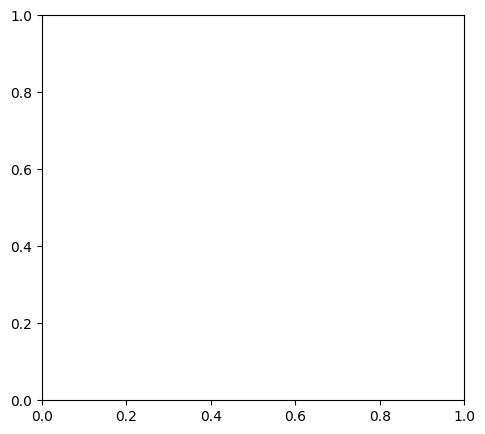

In [18]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(reg_values, num_states, 'o')
plt.xlabel('Regularization parameter')
plt.ylabel('Number of internal states')
plt.xscale('log')
plt.title('L1')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(reg_values, acc, 'o')
plt.xlabel('Regularization parameter')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.title('L1')
plt.grid(True)

plt.show()

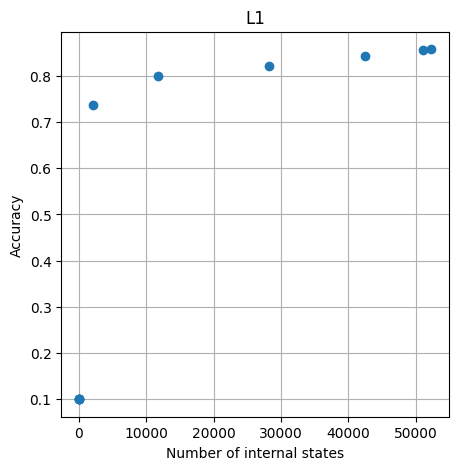

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(num_states, acc, 'o')
plt.xlabel('Number of internal states')
plt.ylabel('Accuracy')
plt.title('L1')
plt.grid(True)
plt.show()

### --- AÑADIDO: Estudio detallado L1 / L2 (1e-2 .. 1.0) vs número de estados

Las siguientes celdas amplían el notebook original con: plan experimental, preprocesado recomendado, varias definiciones de `num_states` (DBSCAN con eps automático y conteo por redondeo), métricas de colapso (normas, pesos cerca de cero, neuronas muertas), un pipeline de barrido corto para L1 y L2 en el rango crítico, y visualizaciones de diagnóstico.
Se marca claramente la separación entre lo que ya había (arriba) y lo añadido aquí (esta sección). Ejecuta las celdas nuevas secuencialmente.

## Mini-report (insertar antes de ejecutar): diseño experimental
- Objetivo: caracterizar cómo L1 y L2 (valores entre 1e-2 y 1.0) modifican el número de estados internos y por qué L1 grande tiende a colapsar la representación.
- Plan: barrido para L1 y L2 con valores: [1e-2, 3e-2, 1e-1, 3e-1, 1.0], 3 seeds, entrenamiento corto (2-5 ep) para exploración; confirmar puntos críticos con entrenamientos más largos.
- Guardar por run: val_acc, n_states (DBSCAN y round), eps, l1/l2 norms, % pesos ~0, neuronas muertas, mean/var activaciones.
- Preprocesado: recomendamos centrar y escalar entrada por píxel (zero-mean, unit-variance) y estandarizar activaciones por neurona antes de usar distancias euclídeas.

In [18]:
# Requisitos: importaciones extra usadas en las celdas añadidas
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances
import torch
import time
import math

# Nota: las variables y funciones originales del notebook (Net, train_dataloader, test_dataloader, train_images, test_images) se usan aquí.

In [19]:
# 1) Preprocesado de entrada: centrar y escalar por píxel (fit con training set)
def fit_input_scaler(train_images):
    # train_images: (N, H, W) en numpy con valores tipo float (actualmente 0..1)
    X = train_images.reshape(-1, 28*28).astype(np.float64)
    scaler = StandardScaler().fit(X)
    return scaler

def transform_images_with_scaler(images, scaler):
    X = images.reshape(-1, 28*28).astype(np.float32)
    Xs = scaler.transform(X)
    return Xs.reshape(-1,28,28)

# Ejemplo: (no ejecuta por defecto, el usuario lo puede activar)
# scaler = fit_input_scaler(train_images)
# train_images_scaled = transform_images_with_scaler(train_images, scaler)
# test_images_scaled  = transform_images_with_scaler(test_images, scaler)
# luego crear dataloaders si se desea usar la versión escalada

In [20]:
# 2) Funciones para normalizar activaciones y medir num_states por varios métodos
import numpy as np

def standardize_activations(H):
    # H: (N, neurons)
    mu = H.mean(axis=0, keepdims=True)
    sd = H.std(axis=0, keepdims=True)
    sd[sd == 0] = 1.0
    return (H - mu) / sd

def num_states_round(H, decimals=2):
    # Round each activation column and count unique rows
    Hr = np.round(H, decimals=decimals)
    return np.unique(Hr, axis=0).shape[0]

def choose_eps_elbow(X, sample=2000, random_state=0):
    # k-NN distance elbow heuristic (2nd derivative)
    n = X.shape[0]
    if n > sample:
        idx = np.random.RandomState(random_state).choice(n, sample, replace=False)
        Xs = X[idx]
    else:
        Xs = X
    nbrs = NearestNeighbors(n_neighbors=2, n_jobs=-1).fit(Xs)
    d = nbrs.kneighbors(Xs)[0][:,1]
    s = np.sort(d)
    grad2 = np.gradient(np.gradient(s))
    k = np.argmax(grad2)
    eps = float(s[k])
    if not (eps > 0 and np.isfinite(eps)):
        eps = float(np.percentile(d, 90))
    return eps, s

def num_states_dbscan(H, auto_eps=True, min_samples=2):
    # H expected to be standardized per neuron for euclidean distances
    Hn = H.copy()
    if auto_eps:
        eps, _ = choose_eps_elbow(Hn)
    else:
        eps = 0.5
    db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1).fit(Hn)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    return {'eps': eps, 'n_states': int(n_clusters), 'n_noise': int((labels == -1).sum()), 'labels': labels}

In [21]:
# 3) Métricas de colapso y diagnóstico por capa y activaciones
def collapse_metrics(net, H_sample=None):
    # Extrae normas y porcentajes de pesos cercanos a 0 por capa
    w1 = net.fc1.weight.detach().cpu().numpy().ravel()
    w2 = net.fc2.weight.detach().cpu().numpy().ravel()
    cm = {
        'l1_norm_w1': float(np.abs(w1).sum()),
        'l1_norm_w2': float(np.abs(w2).sum()),
        'l2_norm_w1': float(np.sqrt((w1**2).sum())),
        'l2_norm_w2': float(np.sqrt((w2**2).sum())),
        'pct_weights_near0_w1': float((np.abs(w1) < 1e-6).mean()),
        'pct_weights_near0_w2': float((np.abs(w2) < 1e-6).mean())
    }
    if H_sample is not None:
        H = H_sample.copy()
        cm['pct_zero_activations'] = float((np.abs(H) < 1e-8).mean())
        cm['dead_neurons_ratio'] = float((H.std(axis=0) < 1e-8).mean())
        cm['mean_activation'] = float(np.abs(H).mean())
    return cm

In [22]:
# 4) Pipeline de barrido corto para L1 / L2 (rango crítico).
import numpy as np
import pandas as pd

def run_reg_sweep(reg_type='L1', reg_values=None, epochs=3, repeats=3, device='cpu'):
    rows = []
    for val in reg_values:
        for seed in range(repeats):
            torch.manual_seed(1000 + seed)
            net = Net().to(device)
            criterion = nn.CrossEntropyLoss()
            if reg_type == 'L2':
                optimizer = optim.Adam(net.parameters(), weight_decay=float(val))
            else:
                optimizer = optim.Adam(net.parameters())
            # Train corto
            for ep in range(epochs):
                net.train()
                for x, t in train_dataloader:
                    optimizer.zero_grad()
                    out = net(x)
                    loss = criterion(out, t)
                    if reg_type == 'L1':
                        l1_term = torch.norm(net.fc1.weight, p=1) + torch.norm(net.fc2.weight, p=1)
                        loss = loss + float(val) * l1_term
                    loss.backward()
                    optimizer.step()
            # Evaluación
            net.eval()
            correct = 0; total = 0
            with torch.no_grad():
                for x, t in test_dataloader:
                    out = net(x)
                    pred = out.argmax(dim=1)
                    correct += (pred == t).sum().item()
                    total += t.size(0)
            val_acc = correct / total
            # Obtener activaciones de una muestra del training set (rápido)
            Xtrain = train_images.reshape(-1, 28*28)
            idx = np.random.RandomState(0).choice(Xtrain.shape[0], min(2000, Xtrain.shape[0]), replace=False)
            Xs = Xtrain[idx]
            with torch.no_grad():
                H = net.hidden_layer(torch.tensor(Xs, dtype=torch.float)).cpu().numpy()
            H_std = standardize_activations(H)
            s_db = num_states_dbscan(H_std, auto_eps=True)
            s_round = num_states_round(H_std, decimals=2)
            cm = collapse_metrics(net, H_sample=H)
            row = {'reg_type': reg_type, 'reg_val': float(val), 'seed': seed, 'val_acc': float(val_acc),
                   'n_states_dbscan': s_db['n_states'], 'eps': float(s_db['eps']), 'n_states_round2': int(s_round), **cm}
            rows.append(row)
            print(f"{reg_type}={val:.2g} seed={seed} val_acc={val_acc:.3f} n_states_dbscan={s_db['n_states']} l1norm_w1={cm['l1_norm_w1']:.4g}")
    df = pd.DataFrame(rows)
    return df

# Ejemplo de ejecución (descomentar para correr):
lvals = [1e-2, 3e-2, 1e-1, 3e-1, 1.0]
df_L1 = run_reg_sweep('L1', lvals, epochs=3, repeats=3)
df_L2 = run_reg_sweep('L2', lvals, epochs=3, repeats=3)

L1=0.01 seed=0 val_acc=0.673 n_states_dbscan=2 l1norm_w1=38.6
L1=0.01 seed=1 val_acc=0.683 n_states_dbscan=2 l1norm_w1=38.06
L1=0.01 seed=1 val_acc=0.683 n_states_dbscan=2 l1norm_w1=38.06
L1=0.01 seed=2 val_acc=0.687 n_states_dbscan=1 l1norm_w1=38.07
L1=0.01 seed=2 val_acc=0.687 n_states_dbscan=1 l1norm_w1=38.07
L1=0.03 seed=0 val_acc=0.100 n_states_dbscan=1 l1norm_w1=5.753
L1=0.03 seed=0 val_acc=0.100 n_states_dbscan=1 l1norm_w1=5.753
L1=0.03 seed=1 val_acc=0.100 n_states_dbscan=1 l1norm_w1=5.68
L1=0.03 seed=1 val_acc=0.100 n_states_dbscan=1 l1norm_w1=5.68
L1=0.03 seed=2 val_acc=0.100 n_states_dbscan=1 l1norm_w1=5.79
L1=0.03 seed=2 val_acc=0.100 n_states_dbscan=1 l1norm_w1=5.79
L1=0.1 seed=0 val_acc=0.100 n_states_dbscan=3 l1norm_w1=5.879
L1=0.1 seed=0 val_acc=0.100 n_states_dbscan=3 l1norm_w1=5.879
L1=0.1 seed=1 val_acc=0.100 n_states_dbscan=1 l1norm_w1=5.806
L1=0.1 seed=1 val_acc=0.100 n_states_dbscan=1 l1norm_w1=5.806
L1=0.1 seed=2 val_acc=0.100 n_states_dbscan=1 l1norm_w1=5.897
L1

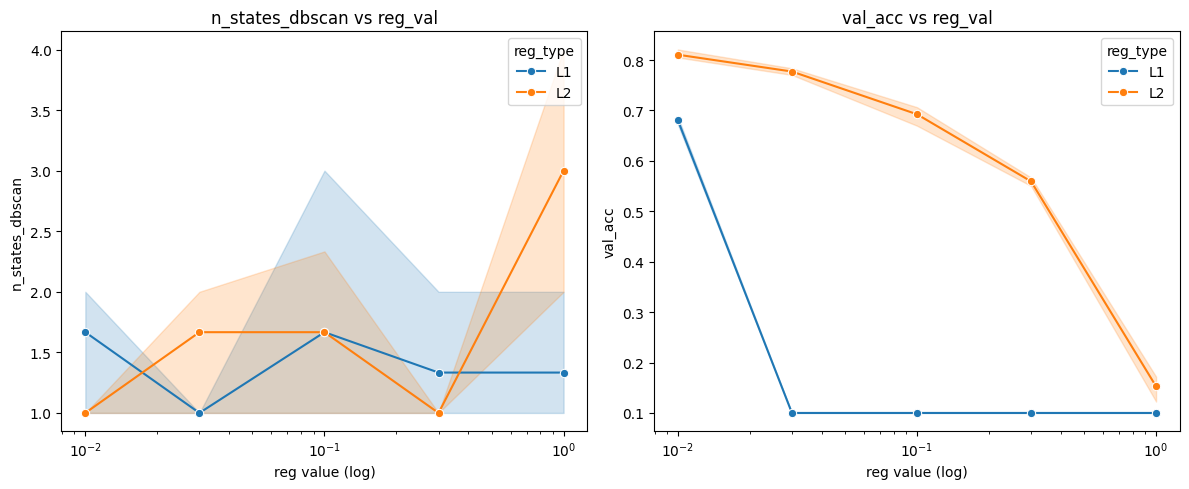

In [23]:
# 5) Visualizaciones rápidas de resultado tras ejecutar el barrido
import seaborn as sns

def plot_sweep_results(df, title='sweep'):
    if df is None or df.shape[0] == 0:
        print('DataFrame vacío')
        return
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    sns.lineplot(data=df, x='reg_val', y='n_states_dbscan', hue='reg_type', estimator='mean', marker='o')
    plt.xscale('log')
    plt.xlabel('reg value (log)')
    plt.title('n_states_dbscan vs reg_val')
    plt.subplot(1,2,2)
    sns.lineplot(data=df, x='reg_val', y='val_acc', hue='reg_type', estimator='mean', marker='o')
    plt.xscale('log')
    plt.xlabel('reg value (log)')
    plt.title('val_acc vs reg_val')
    plt.tight_layout()

plot_sweep_results(pd.concat([df_L1, df_L2]))